# Text classification using Deep learning

Todo:<br>
1. Transformers<br>
2. Tweak neural network<br>

## 1. LSTM

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
df = pd.read_csv('questions_processed.csv')
df

,What do you want to know about GCSE Computer Science?,Section
0,a lot of coding knowing components and etc,2c
1,Advanced Coding,2c
2,Do we do use python or repl.it for coding,2d
3,Do we get to programme bots and stuff like that.,2d
4,do we go through the things we did in year 7 a...,2e
...,...,...
126,"Will the course involve programmings. if yes, ...",2c
127,Will we be able to create our own apps?,2d
128,Will we learn about how people steal passwords...,2a
129,Would there be things in Computer science and ...,5b


In [3]:
training_data = df[df.columns[0]].to_numpy()
training_data = np.reshape(training_data,(-1,1))
training_data[:3]

array([['a lot of coding knowing components and etc'],
       ['Advanced Coding'],
       ['Do we do use python or repl.it for coding']], dtype=object)

In [4]:
vectorizer = layers.TextVectorization(output_mode="int")
vectorizer.adapt(training_data)
integer_data = vectorizer(training_data)
print(integer_data)

tf.Tensor(
[[ 28  56  10 ...   0   0   0]
 [293  21   0 ...   0   0   0]
 [ 11   4  11 ...   0   0   0]
 ...
 [  6   4  25 ...   0   0   0]
 [ 31  27  16 ...   0   0   0]
 [ 11   4  25 ...   0   0   0]], shape=(131, 28), dtype=int64)


In [5]:
max_features = 2000
embedding_dim = 200

inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorizer(inputs)
x = layers.Embedding(max_features + 1, embedding_dim)(x)
x = layers.Dropout(0.5)(x)

#x = layers.SpatialDropout1D(0.2)(x)
#x = layers.LSTM(10, dropout=0.2, recurrent_dropout=0.2)(x)
x = tf.keras.layers.GRU(10)(x)

# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
# x = layers.Bidirectional(layers.LSTM(64))(x)

x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dropout(0.3)(x)
num_classes = 10
outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 200)         400200    
                                                                 
 dropout (Dropout)           (None, None, 200)         0         
                                                                 
 gru (GRU)                   (None, 10)                6360      
                                                                 
 dense (Dense)               (None, 100)               1100      
                                                             

In [6]:
from sklearn.model_selection import train_test_split
labels = df[df.columns[1]]
y = np.argmax(pd.get_dummies(labels).to_numpy(), axis=1)
X_train, X_test, y_train, y_test = train_test_split(training_data, y, test_size=0.20, random_state=42, stratify=y)

In [7]:
np.unique(y_train,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([ 2,  2, 53,  7, 16,  2,  8,  4,  1,  9], dtype=int64))

In [8]:
np.unique(y_test,return_counts=True)

(array([1, 2, 3, 4, 6, 7, 8, 9], dtype=int64),
 array([ 1, 14,  2,  4,  2,  1,  1,  2], dtype=int64))

In [9]:
import os
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    keras.callbacks.TensorBoard(logdir)
]
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=callbacks)
%load_ext tensorboard
%tensorboard --logdir logs

Epoch 1/10
3/3 [==============================] - 2s 264ms/step - loss: 2.2897 - acc: 0.3494 - val_loss: 2.2610 - val_acc: 0.6190
Epoch 2/10
3/3 [==============================] - 0s 40ms/step - loss: 2.2619 - acc: 0.4819 - val_loss: 2.2104 - val_acc: 0.6190
Epoch 3/10
3/3 [==============================] - 0s 45ms/step - loss: 2.2201 - acc: 0.4819 - val_loss: 2.1395 - val_acc: 0.6190
Epoch 4/10
3/3 [==============================] - 0s 44ms/step - loss: 2.1615 - acc: 0.4819 - val_loss: 2.0442 - val_acc: 0.6190
Epoch 5/10
3/3 [==============================] - 0s 36ms/step - loss: 2.0849 - acc: 0.4819 - val_loss: 1.9217 - val_acc: 0.6190
Epoch 6/10
3/3 [==============================] - 0s 53ms/step - loss: 1.9777 - acc: 0.4819 - val_loss: 1.7773 - val_acc: 0.6190
Epoch 7/10
3/3 [==============================] - 0s 44ms/step - loss: 1.8840 - acc: 0.4819 - val_loss: 1.6271 - val_acc: 0.6190
Epoch 8/10
3/3 [==============================] - 0s 44ms/step - loss: 1.8082 - acc: 0.4819 - va

In [10]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 40ms/step - loss: 1.6607 - acc: 0.5185


[1.6606857776641846, 0.5185185074806213]

In [11]:
predictions = model.predict(X_test)
print(predictions.shape)

(27, 10)


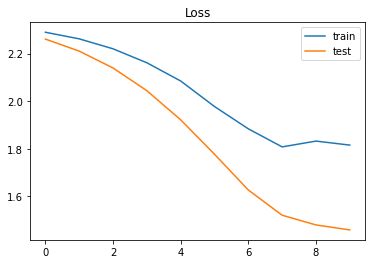

In [12]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 2. Transformers

In [59]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [89]:
training_data_tr = df[df.columns[0]].apply(lambda x: x.split())
training_data_tr = training_data_tr.to_list()
training_data_tr[:3]

[['a', 'lot', 'of', 'coding', 'knowing', 'components', 'and', 'etc'],
 ['Advanced', 'Coding'],
 ['Do', 'we', 'do', 'use', 'python', 'or', 'repl.it', 'for', 'coding']]

In [90]:
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(training_data_tr, y,
                                                                test_size=0.20, random_state=42, stratify=y)

In [81]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each sentence

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model_tr = keras.Model(inputs=inputs, outputs=outputs)

model_tr.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_tr.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 32)          646400    
 g_5 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_5 (Transf  (None, 200, 32)          10656     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_5   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_24 (Dropout)        (None, 32)                0   

In [98]:
history_tr = model_tr.fit(X_train_tr, y_train_tr, epochs=10, batch_size=32)

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'str\'>"})'}), <class 'numpy.ndarray'>

In [ ]:
model_tr.evaluate(X_test_tr,y_test_tr)

In [ ]:
predictions_tr = model_tr.predict(X_test_tr)
print(predictions_tr.shape)

In [ ]:
plt.title('Loss')
plt.plot(history_tr.history['loss'], label='train')
plt.plot(history_tr.history['val_loss'], label='test')
plt.legend()
plt.show()